# Build a robo advisors 
...that measures investors' risk tolerance

Firstly, explore how risk tolerance changed after the financial crisis in 2007-2009. The hypothesis is that investors might become more risk adverse after going through the economic turmoil that possibly caused asset losses or decreased income spared for investments.

The dataset is retrieved from the Survey of Consumer Finances (SCF). The 2007-2009 dataset contains survey results about household demographics, net worth, assets in 2017 (pre-crisis) and 2009 (post-crisis). The 2016 dataset is the most recent as of the time that this project is conducted (18 August 2021). 

- Source links for Excel/CSV files:
[2007-2009](https://www.federalreserve.gov/econres/scf_2009p.htm) [2016](https://www.federalreserve.gov/econres/scf_2016.htm)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import copy

import pandas_datareader.data as web
import yfinance as yf

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
pd.options.display.float_format = '{:,.4f}'.format

In [2]:
# Load 2007-2009 Excel data 
# May takes some time to load

dataset = pd.read_excel('StockData/SCFP2009panel.xlsx', engine='openpyxl', sheet_name='SCFP2009panel', header=0)

In [3]:
# 19285, 515 - excluding a header row

assert dataset.shape == (19285, 515), "Incorrect data size"

In [4]:
dataset.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,NHMORTPCT,WAGEINCPCT,BUSSEFARMINCPCT,INTDIVINCPCT,KGINCPCT,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I
0,1,11,"11,668.1342",47,3,12,2,1,0,2,...,-21.0526,-32.9318,0.0000,"15,939.2789",0.0000,0.0000,0.0000,93.1252,270.4031,57
1,1,12,"11,823.4565",47,3,12,2,1,0,2,...,-21.0526,-32.9318,0.0000,"15,939.2789",0.0000,0.0000,0.0000,93.1252,249.5936,57
2,1,13,"11,913.2284",47,3,12,2,1,0,2,...,-50.0000,-32.9318,0.0000,"15,939.2789",0.0000,0.0000,0.0000,93.1252,209.2334,57
3,1,14,"11,929.3943",47,3,12,2,1,0,2,...,-33.3333,-32.9318,0.0000,"15,939.2789",0.0000,0.0000,0.0000,93.1252,209.2732,57
4,1,15,"11,917.7229",47,3,12,2,1,0,2,...,-38.5965,-32.9318,0.0000,"15,939.2789",0.0000,0.0000,0.0000,93.1252,232.6908,57


In [5]:
print(dataset.columns.tolist())

['YY1', 'Y1', 'WGT09', 'AGE07', 'AGECL07', 'EDUC07', 'EDCL07', 'MARRIED07', 'KIDS07', 'LIFECL07', 'FAMSTRUCT07', 'RACECL', 'H_RACECL', 'RACE', 'H_RACE', 'OCCAT107', 'OCCAT207', 'INDCAT07', 'HHEALTH07', 'SPHEALTH07', 'INCOME07', 'WAGEINC07', 'BUSSEFARMINC07', 'INTDIVINC07', 'KGINC07', 'SSRETINC07', 'TRANSFOTHINC07', 'PENACCTWD07', 'NORMINC07', 'RISK07', 'PSAVING07', 'WSAVED07', 'SAVED07', 'SAVRES1', 'SAVRES2', 'SAVRES3', 'SAVRES4', 'SAVRES5', 'SAVRES6', 'SAVRES7', 'SAVRES8', 'SAVRES9', 'SPENDMOR07', 'LATE6007', 'USPELL07', 'AGEFT07', 'AGEALL07', 'POSTRWORK07', 'RFULL07', 'BSHOPNONE07', 'BSHOPGRDL07', 'BSHOPMODR07', 'ISHOPNONE07', 'ISHOPGRDL07', 'ISHOPMODR07', 'BCALL07', 'BMAGZNEWS07', 'BMAILADTV07', 'BINTERNET07', 'BFRIENDWORK07', 'BFINPRO07', 'BSELF07', 'BDONT07', 'BOTHER07', 'ICALL07', 'IMAGZNEWS07', 'IMAILADTV07', 'IINTERNET07', 'IFRIENDWORK07', 'IFINPRO07', 'ISELF07', 'IDONT07', 'IOTHER07', 'BFINPLAN07', 'IFINPLAN07', 'APPLIED07', 'DENIED07', 'FULLAMT07', 'FEARED07', 'CHECKING07', '

## Data exploration and cleaning

As the dataset consists of 515 columns, it looks wise to condense it with necessary features suitable for business questions.

The objective of this project is to gauge individual's risk tolerance (as dependent variable) in response to three major feature categories: demographic, financial and behavioural.

#### Dependent variable: risk tolerance
- Risk tolearance ratio: as a function of **total risky assets / total assets**
- Total assets = total risky assets + total risk-free assets
- Risky assets: NMMFXX, STOCKSXX, BONDXX
- Risk-free assetes: LIQXX, CDSXX, SAVBNDXX, CASHLIXX
- XX is a placeholder for a specific year, i.e. XX=07 for the Year of 2007

#### Normalize the risk tolearance for 2009
Normalize risky assets with the price of a stock index (S&P500) in 2007 versus 2009.

#### Independent variables
- demographic: AGE, EDCL, MARRIED, OCCAT1
- financial: WSAVED, NETWORTH, INCOME
- behavioural: RISK

### Calculate risk tolerance ratio by row

In [6]:
# SP500 index data for normalization
# pandas_datareader does not have SP500 data as early as 2007 / 2009

def get_sp500(year):
    '''Return a series of SP500 price indices for the year specified
    Source of the data is Yahoo Finance
    '''
    
    try:
        sp500 = yf.Ticker('^GSPC')
        start = dt.datetime(int(year),1,1)
        end = dt.datetime(int(year),12,31)
        
    except:
        raise ValueError('The input year is out of the data range')
    
    return sp500.history(start=start, end=end)['Close']

In [7]:
# Get average closing price for each year of 2007 and 2009
# And calculate the normalizer

Avg_SP07 = get_sp500(2007).mean()
Avg_SP09 = get_sp500(2009).mean()
normalizer = Avg_SP09 / Avg_SP07

print(f'Average stock index in 2007 and 2009 respectively: {Avg_SP07:.2f}, {Avg_SP09:.2f}')

Average stock index in 2007 and 2009 respectively: 1477.22, 947.21


In [8]:
def calculate_RT_ratio(df, year:int):
    ''' Calculate risk tolerance ratio for individual in a particular year.
    Return Pandas Series. 
    '''
    
    # Check for input 
    if len(str(year)) == 4:
        year = str(year)[2:]
    else:
        raise ValueError('Input year must follow the 4-digit format YYYY')
    
    risky_cols = ['NMMF', 'STOCKS', 'BOND']
    riskfree_cols = ['LIQ', 'CDS', 'SAVBND', 'CASHLI']
    
    risky_cols = [col+year for col in risky_cols]
    riskfree_cols = [col+year for col in riskfree_cols]

    
    try:
        risky = df.loc[:, risky_cols].sum(axis=1)
        riskfree = df.loc[:, riskfree_cols].sum(axis=1)        
        total = risky + riskfree
        
    except:
        print('The input dataframe does not have required columns')

    return risky, riskfree, risky/total


In [39]:
# Get risk tolerance rate

dataset['Risky07'], dataset['RiskFree07'], dataset['RT07'] = calculate_RT_ratio(dataset, 2007)
dataset['Risky09'], dataset['RiskFree09'], dataset['RT09'] = calculate_RT_ratio(dataset, 2009)

# Normalize risk tolerance ratio in 2009 with SP500 

dataset['RT09'] = dataset['RT09'] * normalizer

In [40]:
dataset.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I,Risky07,RiskFree07,RT07,Risky09,RiskFree09,RT09
0,1,11,"11,668.1342",47,3,12,2,1,0,2,...,0.0000,93.1252,270.4031,57,0.0000,"7,994.8138",0.0000,17000,16000,0.3303
1,1,12,"11,823.4565",47,3,12,2,1,0,2,...,0.0000,93.1252,249.5936,57,0.0000,"7,994.8138",0.0000,18000,19000,0.3119
2,1,13,"11,913.2284",47,3,12,2,1,0,2,...,0.0000,93.1252,209.2334,57,0.0000,"7,984.4579",0.0000,12000,13000,0.3078
3,1,14,"11,929.3943",47,3,12,2,1,0,2,...,0.0000,93.1252,209.2732,57,0.0000,"7,984.4579",0.0000,13000,25000,0.2194
4,1,15,"11,917.7229",47,3,12,2,1,0,2,...,0.0000,93.1252,232.6908,57,0.0000,"7,994.8138",0.0000,12000,17000,0.2653


In [128]:
# Create a new dataframe 

dataset2 = copy.deepcopy(dataset)

### Inspect new variables

In [133]:
# Create a subset for ease

newvars = dataset2.iloc[:,-6:]

In [134]:
newvars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19285 entries, 0 to 19284
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Risky07     19285 non-null  float64
 1   RiskFree07  19285 non-null  float64
 2   RT07        18349 non-null  float64
 3   Risky09     19285 non-null  int64  
 4   RiskFree09  19285 non-null  int64  
 5   RT09        18327 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 904.1 KB


There is a data quality issue (null values) in columns that calculated risk tolerances (**RT07**, **RT09**). The interest of this project is to see if there has been a change in the level of risk tolerance between 2007 and 2009. Therefore these two variables are important. Let's dig into the reasons why the null values and handle the problem.

In [135]:
dataset2.isnull().values.any()

True

In [136]:
def check_null(df):
    ''' Check if any null values exist in a dataframe
    and print the results only when there is a data quality issue
    '''
    is_null = df.isnull().values.any()
    
    if is_null:
        print(f'Null values exist: {df.isnull().values.sum()} values')
    else:
        print('The dataframe is free of null values')
        

In [137]:
check_null(newvars)

Null values exist: 1894 values


In [138]:
newvars[newvars.isna().any(1)]

,Risky07,RiskFree07,RT07,Risky09,RiskFree09,RT09
20,0.0000,"1,035.5976",0.0000,0,0,NaN
21,0.0000,"1,035.5976",0.0000,0,0,NaN
22,0.0000,"1,035.5976",0.0000,0,0,NaN
23,0.0000,"1,035.5976",0.0000,0,0,NaN
24,0.0000,"1,035.5976",0.0000,0,0,NaN
...,...,...,...,...,...,...
19225,0.0000,0.0000,NaN,0,1,0.0000
19226,0.0000,0.0000,NaN,0,1,0.0000
19227,0.0000,0.0000,NaN,0,1,0.0000
19228,0.0000,0.0000,NaN,0,1,0.0000


The null values are created due to zero divisions. The calculated total assets (total risky + total risk free) used as denominator were 0. In more specific, this issue comes from the individual investors who did not have either risky or risk free assets.

As these investors are not of the interest for this project. We can remove the null values. For reference, the below one line code shows that the null data accounts for 7.25% of the total. 

In [123]:
# Calculate how much % null values account for

total_null = dataset2[dataset2.isnull().any(1)].shape[0] 
total_data = dataset2.shape[0]
print(f'Null data accounts for {total_null / total_data * 100 : .2f} %')

Null data accounts for  7.25 %


In [139]:
# Drop null values

dataset2 = dataset2.dropna(axis=0)
assert dataset2.dropna(axis=0).shape[0] == total_data - total_null, "Null values are not correctly dropped. Try again"

### Change in risk tolerance

Create a new variable **RTPercentageChange** to show the individual's difference in risk tolerance between 2007 and 2009.

In [140]:
# Percentage chance in risk tolerance between 2007 and 2009

dataset2['RTPercentChange'] = np.abs(dataset2['RT09']/dataset2['RT07']-1)

In [141]:
# Inspect the new variable

dataset2['RTPercentChange'].value_counts(dropna=False)

NaN       8657
1.0000    1446
inf       1274
4.1317       5
0.4039       5
          ... 
0.4553       1
0.4814       1
0.4580       1
0.4668       1
0.6425       1
Name: RTPercentChange, Length: 4686, dtype: int64

In [143]:
# Inspect np.nan, np.inf

dataset2[dataset2.isin([np.nan, np.inf, -np.inf]).any(1)]

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,PSAVINGPCT,LEVERAGEPCT,I,Risky07,RiskFree07,RT07,Risky09,RiskFree09,RT09,RTPercentChange
0,1,11,"11,668.1342",47,3,12,2,1,0,2,...,93.1252,270.4031,57,0.0000,"7,994.8138",0.0000,17000,16000,0.3303,inf
1,1,12,"11,823.4565",47,3,12,2,1,0,2,...,93.1252,249.5936,57,0.0000,"7,994.8138",0.0000,18000,19000,0.3119,inf
2,1,13,"11,913.2284",47,3,12,2,1,0,2,...,93.1252,209.2334,57,0.0000,"7,984.4579",0.0000,12000,13000,0.3078,inf
3,1,14,"11,929.3943",47,3,12,2,1,0,2,...,93.1252,209.2732,57,0.0000,"7,984.4579",0.0000,13000,25000,0.2194,inf
4,1,15,"11,917.7229",47,3,12,2,1,0,2,...,93.1252,232.6908,57,0.0000,"7,994.8138",0.0000,12000,17000,0.2653,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19280,4423,44231,"8,170.9222",50,3,16,4,2,0,1,...,15.8751,-17.1366,57,0.0000,"49,190.8883",0.0000,0,38000,0.0000,NaN
19281,4423,44232,"8,261.8470",50,3,16,4,2,0,1,...,15.8751,-14.6979,57,0.0000,"48,155.2907",0.0000,0,38000,0.0000,NaN
19282,4423,44233,"8,302.2250",50,3,16,4,2,0,1,...,15.8751,-14.8052,57,0.0000,"48,155.2907",0.0000,0,38000,0.0000,NaN
19283,4423,44234,"8,335.3862",50,3,16,4,2,0,1,...,15.8751,-17.0207,57,0.0000,"48,155.2907",0.0000,0,38000,0.0000,NaN


**RTPercentChange** variable produces many np.nan and np.inf values. They are created from zero risk tolerance rate in 2007 (**RT07**).

Those records that resulted in np.inf actually shows the increase in risky asset allocation in 2009 - the opposite of the initial hypothesis where it is assumed that investors would become more risk averse (less risky assets vs risk free, so risk tolerance would decrease). 

The records that produced np.nan shows individuals whose risk tolerance remained at zero. 

Removing these records not only delete substantial amount of data but also will produce biased analysis that deletes all records that do not support hypothesis and is not representative at all. 

Therefore, let's drop **RTPercentChange** variable but create a new variable that represents an absolute change in risk tolerance (RT09 - RT07).

In [155]:
# Delete the RTPercentChange column

dataset2.drop(columns=['RTPercentChange'], inplace=True)

In [156]:
# Create a new RTAbsChange column

dataset2['RTAbsChange'] = dataset2['RT09'] - dataset2['RT07']

In [170]:
# Check again for null values

print(f'Numer of rows with null values: {dataset2.isna().any(1).sum()}')

Numer of rows with null values: 0


In [190]:
dataset2['RTChange'] = np.where(dataset2['RTAbsChange']>0, 'pos' , np.where(dataset2['RTAbsChange']<0, 'neg', 'same'))

In [223]:
for i, val in enumerate(yval):
    print(i, val)

0 8657
1 7001
2 2229


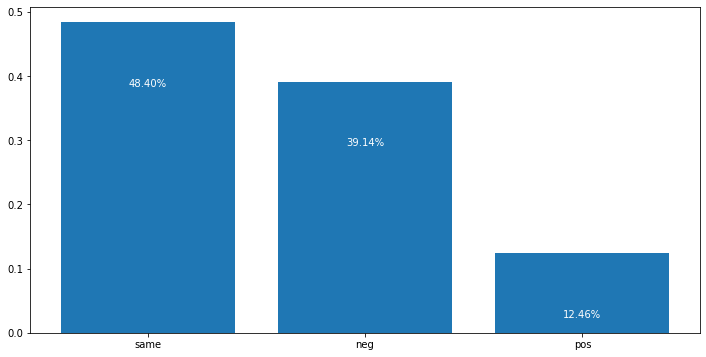

In [252]:
xind = dataset2['RTChange'].value_counts().index
yval = dataset2['RTChange'].value_counts().values
total = dataset2.shape[0]
rel_val = yval / total

plt.bar(x=xind, height=rel_height)
for i, val in enumerate(rel_val):
    text = '{0:.2f}%'.format(val*100)
    plt.text(i, val-0.1, text, horizontalalignment='center', c='white')
plt.show()

Over 48% reported the same risk tolerance. All of these individuals have risk tolerance at 0 in both 2007 and 2009 and it is because they do not hold any risky assets (mutual funds, stocks, bonds) but ontly risk free assets. It is understood that they are completely risk adverse regardless of the market situation, and therefore cannot explain the change in risk tolerance - so are not really of the interest for this project.

For the rest, 39% of the negative risk tolerance represents that individuals became more risk adverse after the financial crisis which supports the initial hypothesis. On the other hand, 12.5% individuals rather became more risk tolerant event after the event.


### Condense dataframe

In [ ]:
features = ['AGE', 'EDCL', 'MARRIED', 'OCCAT1', 'WSAVED', 'NETWORTH', 'INCOME', 'RISK']